In [1]:
import re
import nltk
import pickle
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
from sklearn import tree
from sklearn.svm import SVC
from random import randrange
from bs4 import BeautifulSoup 
from nltk import word_tokenize
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

NB =GaussianNB()
%matplotlib inline

# خواندن مجموعه  داده 

In [2]:
dataset = pd.read_csv("train.csv")
print("Number of rows in train dataset : ",len(dataset))
dataset.head()

Number of rows in train dataset :  19579


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
dataset['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

# تجزیه و تحلیل داده 

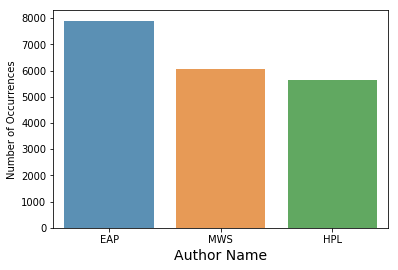

In [4]:
cnt_srs=dataset['author'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot ( cnt_srs.index , dataset['author'].value_counts(),alpha=0.8)# alpha :  ضریب میزان شفافیت رنگ

plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Author Name', fontsize=14)

plt.show()

#  train و devو  test  تقسیم بندی دیتاست به 


In [5]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(dataset.author.values)

xrest, xdev, yrest, ydev = train_test_split(dataset.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
Xrest=pd.DataFrame(xrest)
Yrest=pd.DataFrame(yrest)
Xrest["author"]=Yrest[0]
Xrest.columns = ['text', 'author']

y2 = lbl_enc.fit_transform(Xrest.author.values)

xtrain, xtest, ytrain, ytest = train_test_split(Xrest.text.values, y2, 
                                                  stratify=y2, 
                                                  random_state=42, 
                                                  test_size=0.2222, shuffle=True)

Ydev=pd.DataFrame(ydev)
z0=pickle.dump(Ydev, open('Ydev.pkl','wb'))

Ytrain=pd.DataFrame(ytrain)
z0=pickle.dump(Ytrain, open('Ytrain.pkl','wb'))

Ytest=pd.DataFrame(ytest)
zo=pickle.dump(Ytest, open('Ytest.pkl','wb'))


In [6]:
dataset['author'].value_counts(),pd.DataFrame(y)[0].value_counts()
print(0,'\t:EAP\n',1,'\t:HPL\n',2,'\t:MWS\n')

0 	:EAP
 1 	:HPL
 2 	:MWS



In [7]:
print (xtrain.shape)
print (xtest.shape)
print (xdev.shape)
print (ytrain.shape)
print (ytest.shape)
print (ydev.shape)

(13705,)
(3916,)
(1958,)
(13705,)
(3916,)
(1958,)


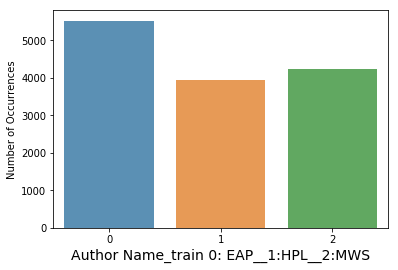

In [8]:

cnt_srs=pd.DataFrame(ytrain)[0].value_counts()
plt.figure(figsize=(6,4))
sns.barplot ( cnt_srs.index , pd.DataFrame(ytrain)[0].value_counts(),alpha=0.8)# alpha :  ضریب میزان شفافیت رنگ

plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Author Name_train 0: EAP__1:HPL__2:MWS', fontsize=14)

plt.show()

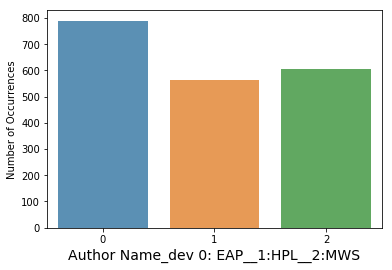

In [9]:
cnt_srs=pd.DataFrame(ydev)[0].value_counts()
plt.figure(figsize=(6,4))
sns.barplot ( cnt_srs.index , pd.DataFrame(ydev)[0].value_counts(),alpha=0.8)# alpha :  ضریب میزان شفافیت رنگ

plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Author Name_dev 0: EAP__1:HPL__2:MWS', fontsize=14)

plt.show()

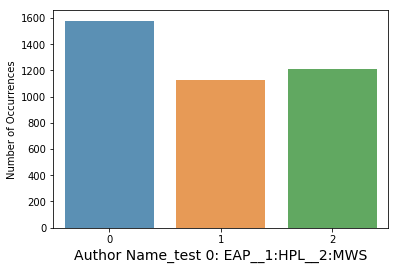

In [10]:
cnt_srs=pd.DataFrame(ytest)[0].value_counts()
plt.figure(figsize=(6,4))
sns.barplot ( cnt_srs.index , pd.DataFrame(ytest)[0].value_counts(),alpha=0.8)# alpha :  ضریب میزان شفافیت رنگ

plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Author Name_test 0: EAP__1:HPL__2:MWS', fontsize=14)

plt.show()

In [11]:
### پاکسازی داده

def cleaning_and_stemming(text, non_alpha=True, normalization=True, stemming=True, stopword=True):
    Beautiful_text = BeautifulSoup(text).get_text() 
    words = word_tokenize(Beautiful_text)
    if non_alpha:
        words = [word for word in words if word.isalpha()]
    if normalization:
        words = [w.lower() for w in words]
    if stopword:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]
    if stemming:
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]
    return( " ".join(words ))



#*************************************************************************************************************************

#  train, test , dev پاکسازی

In [12]:
clean_train=list(range(len(xtrain)))
clean_dev = list(range(len(xdev)))
clean_test = list(range(len(xtest)))
xTrain= pd.DataFrame(xtrain)
xDev=pd.DataFrame(xdev)
xTest=pd.DataFrame(xtest)
clean_train=xTrain[0].apply(lambda x: cleaning_and_stemming(x) ).tolist()
clean_dev=xDev[0].apply ( lambda x: cleaning_and_stemming(x) ).tolist()
clean_test=xTest[0].apply ( lambda x: cleaning_and_stemming(x) ).tolist()

# Creating the BOW_binary

In [13]:
print ("Creating the bag of words binary...\n")
vectorizer = CountVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',ngram_range=(1, 3))

train_BOW_bi = vectorizer.fit_transform(clean_train).toarray()
dev_BOW_bi = vectorizer.transform(clean_dev).toarray()   
test_BOW_bi = vectorizer.transform(clean_test).toarray()  

for i in range (len(train_BOW_bi)):
    for j in range (len(train_BOW_bi[i])):
        if train_BOW_bi[i][j]!=0 :
            train_BOW_bi[i][j]=1
            
for i in range (len(dev_BOW_bi)):
    for j in range (len(dev_BOW_bi[i])):
        if dev_BOW_bi[i][j]!=0 :
            dev_BOW_bi[i][j]=1  
            
for i in range (len(test_BOW_bi)):
    for j in range (len(test_BOW_bi[i])):
        if test_BOW_bi[i][j]!=0 :
            test_BOW_bi[i][j]=1  
            

Creating the bag of words binary...



# Creating the bag of words

In [14]:
print ("Creating the bag of words...\n")
train_BOW = vectorizer.fit_transform(clean_train).toarray()
dev_BOW = vectorizer.transform(clean_dev).toarray()  
test_BOW = vectorizer.transform(clean_test).toarray()  

Creating the bag of words...



# Creating the TF & IDF

In [15]:
print ("Creating the Tfidf ...\n")
vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)


train_TFIDF = vectorizer.fit_transform(clean_train).toarray()
dev_TFIDF = vectorizer.transform(clean_dev).toarray()
test_TFIDF = vectorizer.transform(clean_test).toarray()


Creating the Tfidf ...



In [16]:
Ytrain=pd.DataFrame(ytrain)
Ydev=pd.DataFrame(ydev)
Ytest=pd.DataFrame(ytest)

In [17]:
Fscoer_clf=list (range (1000))
Pred_clf=list (range (1000))

In [18]:
Fscoer_clf_test=list (range (1000))
Pred_clf_test=list (range (1000))

# ساخت 100 تا ترین 

In [19]:
train_TFIDF_D=pd.DataFrame(train_TFIDF)
train_TFIDF_D['lable']=ytrain
train_TFIDF_D=train_TFIDF_D.as_matrix()

dev_TFIDF_D=pd.DataFrame(dev_TFIDF)
dev_TFIDF_D['lable']=ydev
dev_TFIDF_D=dev_TFIDF_D.as_matrix()

C:\Users\5920350\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\5920350\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [20]:
test_TFIDF_D=pd.DataFrame(test_TFIDF)
test_TFIDF_D['lable']=ytest
test_TFIDF_D=test_TFIDF_D.as_matrix()


C:\Users\5920350\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Create a random subsample from the dataset with replacement

def subsample(dataset):
    sample = list()
    for i in range (dataset.shape[0]):
        index = randrange(dataset.shape[0])
        sample.append(dataset[index])
    return sample

def cerat_muliti_dataset(dataset):
    COM_LIST=list(range(100))
    for i in range (len(COM_LIST)):
        COM_LIST[i]=subsample(dataset)
    return COM_LIST
COM_LIST=cerat_muliti_dataset(train_TFIDF_D)  

## 1- LinearSVC

In [78]:
#bow binary
# clf0=LinearSVC(C=2.5, penalty="l2", dual=False ,tol=0.0025).fit(train_BOW_bi,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_0.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_0.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW_bi).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[0]=p_clf0
Fscoer_clf[0]=F_clf0
print('F_clf0=',F_clf0) 

F_clf0= 0.7676200204290092


In [79]:
p_clf1=np.array(z0.predict(test_BOW_bi).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[0]=p_clf1
Fscoer_clf_test[0]=F_clf1
print('F_clf0=',F_clf1) 

F_clf0= 0.7655771195097038


In [80]:
#bow 
# clf0=LinearSVC(C=2.5, penalty="l2", dual=False ,tol=0.0025).fit(train_BOW,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_1.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_1.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[1]=p_clf0
Fscoer_clf[1]=F_clf0
print('F_clf1=',F_clf0) 

F_clf1= 0.7655771195097038


In [81]:
p_clf1=np.array(z0.predict(test_BOW).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[1]=p_clf1
Fscoer_clf_test[1]=F_clf1
print('F_clf1=',F_clf1) 

F_clf1= 0.7630234933605718


In [82]:
#tfidf
# clf0=LinearSVC(C=2.5, penalty="l2", dual=False ,tol=0.0025).fit(train_TFIDF,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_2.pkl','wb'))  ##only for frist run
z0=pickle.load(open('bay_model_2.pkl','rb'))
p_clf0=np.array(z0.predict(dev_TFIDF).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[2]=p_clf0
Fscoer_clf[2]=F_clf0
print('F_clf2=',F_clf0) 

F_clf2= 0.7946884576098059


In [83]:
p_clf1=np.array(z0.predict(test_TFIDF).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[2]=p_clf1
Fscoer_clf_test[2]=F_clf1
print('F_clf2=',F_clf1) 

F_clf2= 0.8003064351378958


In [84]:
#100 train with tfidf

for i in range (3,103):
##only for frist run
#     j=i-3
#     ff=np.array(COM_LIST[j],dtype=float)
#     fff=pd.DataFrame(ff)
#     num=fff.shape[1]-1
#     xcom=fff.iloc[:,0:num].as_matrix()
#     Ycom=pd.DataFrame(fff.iloc[:,-1].as_matrix())
#     clf0=LinearSVC(C=2.5, penalty="l2", dual=False ,tol=0.0025).fit(xcom,Ycom)
#     z0=pickle.dump(clf0, open('bay_model_%d.pkl'%i,'wb'))
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf0=z0.predict(dev_TFIDF)
    F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
    Pred_clf[i]=p_clf0
    Fscoer_clf[i]=F_clf0
#     print('F_clf%d='%i,F_clf0) 



In [85]:
for i in range (3,103):
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf1=z0.predict(test_TFIDF)
    F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
    Pred_clf_test[i]=p_clf1
    Fscoer_clf_test[i]=F_clf1
#     print('F_clf%d='%i,F_clf1) 

## 2- NB

In [86]:
#bow binary
# clf0=GaussianNB().fit(train_BOW_bi,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_103.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_103.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW_bi).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[103]=p_clf0
Fscoer_clf[103]=F_clf0
print('F_clf103=',F_clf0) 

F_clf103= 0.660367722165475


In [87]:
p_clf1=np.array(z0.predict(test_BOW_bi).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[103]=p_clf1
Fscoer_clf_test[103]=F_clf1
print('F_clf3=',F_clf1) 

F_clf3= 0.6519407558733401


In [88]:
# bow
# clf0=GaussianNB().fit(train_BOW,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_104.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_104.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[104]=p_clf0
Fscoer_clf[104]=F_clf0
print('F_clf104=',F_clf0)

F_clf104= 0.6613891726251276


In [89]:
p_clf1=np.array(z0.predict(test_BOW).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[104]=p_clf1
Fscoer_clf_test[104]=F_clf1
print('F_clf104=',F_clf1) 

F_clf104= 0.6521961184882533


In [90]:
#tfidf
# clf0=GaussianNB().fit(train_TFIDF,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_105.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_105.pkl','rb'))
p_clf0=np.array(z0.predict(dev_TFIDF).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[105]=p_clf0
Fscoer_clf[105]=F_clf0
print('F_clf105=',F_clf0) 

F_clf105= 0.6736465781409602


In [91]:
p_clf1=np.array(z0.predict(test_TFIDF).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[105]=p_clf1
Fscoer_clf_test[105]=F_clf1
print('F_clf105=',F_clf1) 

F_clf105= 0.6557711950970377


In [92]:
for i in range (106,206):
##only for frist run
#     j=i-106
#     ff=np.array(COM_LIST[j],dtype=float)
#     fff=pd.DataFrame(ff)
#     num=fff.shape[1]-1
#     xcom=fff.iloc[:,0:num].as_matrix()
#     Ycom=pd.DataFrame(fff.iloc[:,-1].as_matrix())
#     clf0=GaussianNB().fit(xcom,Ycom)
#     z0=pickle.dump(clf0, open('bay_model_%d.pkl'%i,'wb'))
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf0=z0.predict(dev_TFIDF)
    F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
    Pred_clf[i]=p_clf0
    Fscoer_clf[i]=F_clf0
#     print('F_clf%d='%i,F_clf0) 


In [93]:
for i in range (106,206):
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf1=z0.predict(test_TFIDF)
    F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
    Pred_clf_test[i]=p_clf1
    Fscoer_clf_test[i]=F_clf1
#     print('F_clf%d='%i,F_clf1) 

# 3-LogisticRegression()

In [94]:
#bow binary
# clf0=LogisticRegression().fit(train_BOW_bi,Ytrain) ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_206.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_206.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW_bi).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[206]=p_clf0
Fscoer_clf[206]=F_clf0
print('F_clf206=',F_clf0) 


F_clf206= 0.7967313585291115


In [95]:
p_clf1=np.array(z0.predict(test_BOW_bi).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[206]=p_clf1
Fscoer_clf_test[206]=F_clf1
print('F_clf206=',F_clf1) 

F_clf206= 0.8064351378958121


In [96]:
#bow 
# clf0=LogisticRegression().fit(train_BOW,Ytrain)  ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_207.pkl','wb')) ##only for frist run
z0=pickle.load(open('bay_model_207.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[207]=p_clf0
Fscoer_clf[207]=F_clf0
print('F_clf207=',F_clf0) 

F_clf207= 0.7941777323799797


In [97]:
p_clf1=np.array(z0.predict(test_BOW).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[207]=p_clf1
Fscoer_clf_test[207]=F_clf1
print('F_clf207=',F_clf1) 

F_clf207= 0.8082226762002043


In [99]:
#tfidf
# clf0=LogisticRegression(C=8).fit(train_TFIDF,Ytrain)  ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_208.pkl','wb'))  ##only for frist run
z0=pickle.load(open('bay_model_208.pkl','rb'))
p_clf0=np.array(z0.predict(dev_TFIDF).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[208]=p_clf0
Fscoer_clf[208]=F_clf0
print('F_clf208=',F_clf0) 

F_clf208= 0.810520939734423


In [100]:
p_clf1=np.array(z0.predict(test_TFIDF).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[208]=p_clf1
Fscoer_clf_test[208]=F_clf1
print('F_clf208=',F_clf1) 

F_clf208= 0.8158835546475995


In [101]:
for i in range (209,308):
##only for frist run
#     j=i-209
#     ff=np.array(COM_LIST[j],dtype=float)
#     fff=pd.DataFrame(ff)
#     num=fff.shape[1]-1
#     xcom=fff.iloc[:,0:num].as_matrix()
#     Ycom=pd.DataFrame(fff.iloc[:,-1].as_matrix())
#     clf0=LogisticRegression(C=8).fit(xcom,Ycom)
#     z0=pickle.dump(clf0, open('bay_model_%d.pkl'%i,'wb'))
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf0=z0.predict(dev_TFIDF)
    F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
    Pred_clf[i]=p_clf0
    Fscoer_clf[i]=F_clf0
#     print('F_clf%d='%i,F_clf0) 


In [102]:
for i in range (209,308):
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf1=z0.predict(test_TFIDF)
    F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
    Pred_clf_test[i]=p_clf1
    Fscoer_clf_test[i]=F_clf1
#     print('F_clf%d='%i,F_clf1) 

# 4- ExtraTrees

In [103]:
#bow binary
# clf0=ExtraTreesClassifier().fit(train_BOW_bi,Ytrain)  ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_308.pkl','wb'))  ##only for frist run
z0=pickle.load(open('bay_model_308.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW_bi).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[308]=p_clf0
Fscoer_clf[308]=F_clf0
print('F_clf308=',F_clf0) 

F_clf308= 0.658835546475996


In [104]:
p_clf1=np.array(z0.predict(test_BOW_bi).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[308]=p_clf1
Fscoer_clf_test[308]=F_clf1
print('F_clf308=',F_clf1) 

F_clf308= 0.6695607763023493


In [105]:
#bow 
# clf0=ExtraTreesClassifier().fit(train_BOW,Ytrain)  ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_309.pkl','wb'))  ##only for frist run
z0=pickle.load(open('bay_model_309.pkl','rb'))
p_clf0=np.array(z0.predict(dev_BOW).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[309]=p_clf0
Fscoer_clf[309]=F_clf0
print('F_clf309=',F_clf0) 

F_clf309= 0.68488253319714


In [106]:
p_clf1=np.array(z0.predict(test_BOW).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[309]=p_clf1
Fscoer_clf_test[309]=F_clf1
print('F_clf309=',F_clf1) 

F_clf309= 0.6940755873340143


In [107]:
#tfidf
# clf0=ExtraTreesClassifier().fit(train_TFIDF,Ytrain)  ##only for frist run
# z0=pickle.dump(clf0, open('bay_model_310.pkl','wb'))  ##only for frist run
z0=pickle.load(open('bay_model_310.pkl','rb'))

p_clf0=np.array(z0.predict(dev_TFIDF).tolist(),dtype=float)
F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
Pred_clf[310]=p_clf0
Fscoer_clf[310]=F_clf0
print('F_clf310=',F_clf0) 

F_clf310= 0.702247191011236


In [108]:
p_clf1=np.array(z0.predict(test_TFIDF).tolist(),dtype=float)
F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
Pred_clf_test[310]=p_clf1
Fscoer_clf_test[310]=F_clf1
print('F_clf310=',F_clf1) 

F_clf310= 0.6999489274770173


In [109]:
for i in range (311,411):
##only for frist run
#     j=i-311
#     ff=np.array(COM_LIST[j],dtype=float)
#     fff=pd.DataFrame(ff)
#     num=fff.shape[1]-1
#     xcom=fff.iloc[:,0:num].as_matrix()
#     Ycom=pd.DataFrame(fff.iloc[:,-1].as_matrix())
#     clf0=ExtraTreesClassifier().fit(xcom,Ycom)
#     z0=pickle.dump(clf0, open('bay_model_%d.pkl'%i,'wb'))
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf0=z0.predict(dev_TFIDF)
    F_clf0 = precision_recall_fscore_support(Ydev, p_clf0, average='micro')[2]
    Pred_clf[i]=p_clf0
    Fscoer_clf[i]=F_clf0
#     print('F_clf%d='%i,F_clf0) 


In [110]:
for i in range (311,411):
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    p_clf1=z0.predict(test_TFIDF)
    F_clf1 = precision_recall_fscore_support(Ytest, p_clf1, average='micro')[2]
    Pred_clf_test[i]=p_clf1
    Fscoer_clf_test[i]=F_clf1
#     print('F_clf%d='%i,F_clf1) 

# ذخیره کردن نتایج 

In [113]:
#result dev
#z0_Pred_clf=pickle.dump(Pred_clf[:411], open('Pred_clf0.pkl','wb')) ##only for frist run
z0_Pred_clf=pickle.load(open('Pred_clf0.pkl','rb'))

# z0_Fscoer_clf=pickle.dump(Fscoer_clf[:411], open('Fscoer_clf0.pkl','wb'))##only for frist run
z0_Fscoer_clf=pickle.load(open('Fscoer_clf0.pkl','rb'))

z0_allModels_clf=[]
for i in range (len(z0_Fscoer_clf)):
    z0=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    temp=[]
    temp.append(z0)
    temp.append(z0_Fscoer_clf[i])
    z0_allModels_clf.append(temp)

In [123]:
#result test
#z1_Pred_clf_test=pickle.dump(Pred_clf_test[:411], open('Pred_clf1_test.pkl','wb'))##only for frist run
z1_Pred_clf_test=pickle.load(open('Pred_clf1_test.pkl','rb'))
# z1_Fscoer_clf_test=pickle.dump(Fscoer_clf_test[:411], open('Fscoer_clf1_test.pkl','wb'))##only for frist run
z1_Fscoer_clf_test=pickle.load(open('Fscoer_clf1_test.pkl','rb'))
z1_allModels_clf_test=[]
for i in range (len(z1_Fscoer_clf_test)):
    z1=pickle.load(open('bay_model_%d.pkl'%i,'rb'))
    temp=[]
    temp.append(z1)
    temp.append(z1_Fscoer_clf_test[i])
    z1_allModels_clf_test.append(temp)

# بهترین کلاسیفایر

In [116]:
def best_clasifire(list_allModle,list_Fscore,list_pred,name):
    all_M_D_frame =pd.DataFrame(list_allModle,columns=['Modle','Fscore'])
    best_Fscore=(max(list_Fscore))
    best_Modle=all_M_D_frame[all_M_D_frame['Fscore']==best_Fscore]
    best_pre=list_pred[best_Modle.index[0]]
    return best_Fscore,best_pre,best_Modle

# رای گیری اکثریت

In [117]:
def modle_voting (lable,predict_list,name):
    Columns=[]
    for i in range(len(predict_list[0])) :
        Columns.append('pred%d'%i)
    df=pd.DataFrame(predict_list,columns=Columns)
    pre_final=[]
    for i in range (df.shape[1]):
        a=df['pred%d'%i].tolist()
        max_freq=np.bincount(a).tolist() 
        pre_final.append(max_freq.index(max(max_freq)))
    F_eclf1=precision_recall_fscore_support(lable,pre_final, average='micro')[2]
    return F_eclf1,pre_final 



# Forward Selection 

In [118]:
def forward (list_modles,list_pred,lable,name):
    clf_forward=[]
    for i in range (len(list_modles)):
        temp=[]
        temp.append(list_modles[i][1])
        temp.append(list_modles[i][0])
        temp.append(list_pred[i])
        clf_forward.append(temp)
    
    sorted(clf_forward, key = itemgetter(0),reverse=False)
    best_score_forward=clf_forward[0][0]# افسکور
    # print(best_score_forward)
    best_pre_forward=[list_pred[0]]


    for i in range(len(list_pred)):
        templist=best_pre_forward+[clf_forward[i][2]]
        p_voting= modle_voting (lable,templist,name)
        score_forward = p_voting[0]
        pre_forward =p_voting[1]
    
        if score_forward > best_score_forward:
            best_score_forward = score_forward
            best_pre_forward=templist  
        #     print(best_score_forward)
#     print('fscore_Forward%s='%name,best_score_forward)
    return  best_score_forward,best_pre_forward


# Back Ward Elimnation

In [119]:
def backward (list_modles,list_pred,lable,name):
    clf_backward=[]
    for i in range (len(list_modles)):
        temp=[]
        temp.append(list_modles[i][1])
        temp.append(list_modles[i][0])
        temp.append(list_pred[i])
        clf_backward.append(temp)
        
    sorted(clf_backward, key = itemgetter(0),reverse=True)

    predictbl=[]

    for i in range(len(list_pred)):
        predictbl.append(clf_backward[i][2])
    
    backward= modle_voting(lable,list_pred,name)    

    best_score_back=backward[0] 
    best_pre_back = [backward[1]] 

    templist=list (range (len(predictbl)))
    for i in range (1,len(predictbl)):
        templist[i]=predictbl[:-i]

    for i in range(1,len(predictbl)):#
        p_voting= modle_voting (lable,templist[i],name)
        if best_score_back < p_voting[0]:
            best_score_back = p_voting[0]
#             print(best_score_back)
            best_pre_back=templist[i]
    return best_score_back,best_pre_back

# رای گیری بهترین نتایج

In [186]:
def all_comb (list_allbestpred,lable,name):
    best_score_final = modle_voting(lable,list_allbestpred,name)
    return best_score_final[0]

# نتایج

# dev

In [183]:
best_clasifire_dev=best_clasifire(z0_allModels_clf,z0_Fscoer_clf,z0_Pred_clf,'dev')   
print ('best_clasifire_dev=',best_clasifire_dev[0])

voting_dev=modle_voting(Ydev,z0_Pred_clf,'dev')
print ('voting_dev=',voting_dev[0])

forward_dev=forward (z0_allModels_clf,z0_Pred_clf,Ydev,'dev')
print ('fscore_Forward_dev=',forward_dev[0])

backward_dev=backward (z0_allModels_clf,z0_Pred_clf,Ydev,'dev')
print ('fscore_Backward_dev=',backward_dev[0])


best_predict_final_dev = backward_dev[1]+forward_dev[1]+[np.array(voting_dev[1],dtype=float)]+[best_clasifire_dev[1]]
all_comb_dev=all_comb (best_predict_final_dev,Ydev,"dev")
print('best_score_final_dev=',all_comb_dev)

best_clasifire_dev= 0.810520939734423
voting_dev= 0.8202247191011236
fscore_Forward_dev= 0.8227783452502554
fscore_Backward_dev= 0.823799795709908
best_score_final_dev= 0.823799795709908


# test

In [184]:
best_clasifire_test=best_clasifire(z1_allModels_clf_test,z1_Fscoer_clf_test,z1_Pred_clf_test,'test')  
print ('best_clasifire_test=',best_clasifire_test[0])

voting_test=modle_voting(Ytest,z1_Pred_clf_test,'test')
print ('voting_test=',voting_test[0])

forward_test=forward (z1_allModels_clf_test,z1_Pred_clf_test,Ytest,'test')
print ('fscore_Forward_test=',forward_test[0])

backward_test= backward(z1_allModels_clf_test,z1_Pred_clf_test,Ytest,'test')
print ('fscore_backward_test=',backward_test[0])

best_predict_final_test = backward_test[1]+forward_test[1]+[np.array(voting_test[1],dtype=float)]+[best_clasifire_test[1]]
all_comb_test=all_comb (best_predict_final_test,Ytest,"test")
print('best_score_final_test=',all_comb_test)

best_clasifire_test= 0.8158835546475995
voting_test= 0.822267620020429
fscore_Forward_test= 0.8225229826353422
fscore_backward_test= 0.8235444330949949
best_score_final_test= 0.822012257405516


# اعمال فیلتر بر روی افسکور 

# dev

In [196]:
Pred_clf=[]
allModels_clf=[]
Fscoer_clf=[]
Pred_clf=[]

mean_fscore = sum (z0_Fscoer_clf) / len(z0_allModels_clf)
for i in range (len(z0_allModels_clf)):
    if z0_Fscoer_clf[i] > mean_fscore :
        Fscoer_clf.append(z0_Fscoer_clf[i])
        allModels_clf.append(z0_allModels_clf[i])
        Pred_clf.append(z0_Pred_clf[i])

len(allModels_clf),len(z0_allModels_clf)     

(205, 411)

In [199]:
best_clasifire_dev_filter=best_clasifire(allModels_clf,Fscoer_clf,Pred_clf,'dev')   
print ('best_clasifire_dev_filter=',best_clasifire_dev_filter[0])

voting_dev_filter=modle_voting(Ydev,Pred_clf,'dev')
print ('voting_dev_filter=',voting_dev_filter[0])

forward_dev_filter=forward (allModels_clf,Pred_clf,Ydev,'dev')
print ('fscore_Forward_dev_filter=',forward_dev_filter[0])

backward_dev_filter=backward (allModels_clf,Pred_clf,Ydev,'dev')
print ('fscore_Backward_dev_filter=',backward_dev_filter[0])


best_predict_final_dev_filter = backward_dev_filter[1]+forward_dev_filter[1]+[np.array(voting_dev_filter[1],dtype=float)]+[best_clasifire_dev_filter[1]]
all_comb_dev_filter=all_comb (best_predict_final_dev_filter,Ydev,"dev")
print('best_score_final_dev_filter_filter=',all_comb_dev_filter)

best_clasifire_dev= 0.810520939734423
voting_dev_filter= 0.8074565883554647
fscore_Forward_dev_filter= 0.813585291113381
fscore_Backward_dev_filter= 0.8084780388151175
best_score_final_dev_filter_filter= 0.8084780388151175


# test

In [206]:
Pred_clf_testf=[]
allModels_clf_testf=[]
Fscoer_clf_testf=[]
Pred_clf_testf=[]

mean_fscore_test = sum (z1_Fscoer_clf_test) / len(z1_allModels_clf_test)
for i in range (len(z1_allModels_clf_test)):
    if z1_Fscoer_clf_test[i] > mean_fscore_test :
        Fscoer_clf_testf.append(z1_Fscoer_clf_test[i])
        allModels_clf_testf.append(z1_allModels_clf_test[i])
        Pred_clf_testf.append(z1_Pred_clf_test[i])

len(allModels_clf_testf),len(z1_allModels_clf_test)   

(205, 411)

In [209]:
best_clasifire_test_filter=best_clasifire(allModels_clf_testf,Fscoer_clf_testf,Pred_clf_testf,'test')  
print ('best_clasifire_test_filter=',best_clasifire_test_filter[0])

voting_test_filter=modle_voting(Ytest,Pred_clf_testf,'test')
print ('voting_test_filter=',voting_test_filter[0])

forward_test_filter=forward (allModels_clf_testf,Pred_clf_testf,Ytest,'test')
print ('fscore_Forward_test_filter=',forward_test_filter[0])

backward_test_filter= backward(allModels_clf_testf,Pred_clf_testf,Ytest,'test')
print ('fscore_backward_test_filter=',backward_test_filter[0])

best_predict_final_test_filter = backward_test_filter[1]+forward_test_filter[1]+[np.array(voting_test_filter[1],dtype=float)]+[best_clasifire_test_filter[1]]
all_comb_test_filter=all_comb (best_predict_final_test_filter,Ytest,"test")
print('best_score_final_test_filter=',all_comb_test_filter)

best_clasifire_test_filter= 0.8158835546475995
voting_test_filter= 0.8128192032686414
fscore_Forward_test_filter= 0.813585291113381
fscore_backward_test_filter= 0.813585291113381
best_score_final_test_filter= 0.8133299284984679
